# Plot Hovmoller plots of U10 winds

* **Description**: Reads in and creates plots of wind at some level
* **Input data**: CESM2-LE and Rufmod processed vertical files
* **Output data**: PNG figures of trends
* **Creator**: Alice DuVivier
* **Date**: April 2022

The rufmod experiments were performed where the sea ice roughness over Arctic sea ice regions was set to be equal to what it would be over open ocean. This is to better understand ice-atmosphere coupling, processes, and feedbacks.

In [1]:
import xarray as xr
import numpy as np
from datetime import timedelta
import glob

import pop_tools

import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec

import geocat.datafiles as gdf
import geocat.viz.util as gvutil
from geocat.viz import cmaps as gvcmaps
import geocat.comp as gcomp

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress,pearsonr, t

import intake
from distributed import Client
from ncar_jobqueue import NCARCluster

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='32 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    #resource_spec='select=1:ncpus=2:mem=256GB', # Specify resources
    project='P93300665', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(32)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:46804,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Choose variable

In [4]:
# list the variables to load
var_in = 'U10'

# U10, PSL, LHFLX, SHFLX

## Load rufmod experiments

In [5]:
# Load "rufmod" data
#choose cases and data paths
case1 = 'b.e21.BSSP370.f09_g17.rufmod.001'
case2 = 'b.e21.BSSP370.f09_g17.rufmod.002'
case3 = 'b.e21.BSSP370.f09_g17.rufmod.003'
case4 = 'b.e21.BSSP370.f09_g17.rufmod.004'
case5 = 'b.e21.BSSP370.f09_g17.rufmod.005'

# set base directory where all data live
data_dir = '/glade/campaign/cesm/development/pcwg/projects/arctic_cyclones/rufmod_expts/'
# set individual data directories
data_dir1 = data_dir+case1+'/atm/proc/tseries/month_1/'
data_dir2 = data_dir+case2+'/atm/proc/tseries/month_1/'
data_dir3 = data_dir+case3+'/atm/proc/tseries/month_1/'
data_dir4 = data_dir+case4+'/atm/proc/tseries/month_1/'
data_dir5 = data_dir+case5+'/atm/proc/tseries/month_1/'

In [6]:
%%time
#reading in files
ds1 = []
ds2 = []
ds3 = []
ds4 = []
ds5 = []

print("loading "+var_in)   
my_files=sorted(glob.glob(data_dir1+case1+'.cam.h0.'+var_in+'.*.nc'))
ds1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir2+case2+'.cam.h0.'+var_in+'.*.nc'))
ds2=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir3+case3+'.cam.h0.'+var_in+'.*.nc'))
ds3=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')    
my_files=sorted(glob.glob(data_dir4+case4+'.cam.h0.'+var_in+'.*.nc'))
ds4=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir5+case5+'.cam.h0.'+var_in+'.*.nc'))
ds5=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')

# verify it worked - plot first time only
#ds1["aice"].isel(time=0).plot()

loading U10
CPU times: user 986 ms, sys: 412 ms, total: 1.4 s
Wall time: 23.5 s


In [7]:
futures = xr.concat([ds1,ds2,ds3,ds4,ds5],dim='member_id')

In [8]:
futures.member_id.values

# assign member_id as coordinate array
futures.assign_coords({"member_id": futures.member_id.values})

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, member_id: 5, time: 1032, nbnd: 2, lon: 288, lev: 32, ilev: 33)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id     (member_id) int64 0 1 2 3 4
Dimensions without coordinates: nbnd
Data variables: (12/27)
    zlon_bnds     (member_id, time, zlon, nbnd) float64 dask.array<chunksize=(1, 600, 1, 2), meta=np.ndarray>
    gw            (member_id, time, lat) float64 dask.array<chunksize=(1, 600, 192), meta=np.ndarray>
    hyam          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    hybm          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    P0            (member_id, time) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    hyai          (member_id, time, ilev) float64 dask.array<chunksize=(1, 600, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f11vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f12vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    sol_tsi       (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    nsteph        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    U10           (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSSP370.f09_g17.rufmod.001
    logname:           duvivier
    host:              cheyenne3
    initial_file:      b.e21.BHIST.f09_g17.CMIP6-historical.rufmod.cam.i.2015...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [9]:
ds_all = futures

# assign member_id as coordinate array
ds_all.assign_coords({"member_id": ds_all.member_id.values})

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, member_id: 5, time: 1032, nbnd: 2, lon: 288, lev: 32, ilev: 33)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id     (member_id) int64 0 1 2 3 4
Dimensions without coordinates: nbnd
Data variables: (12/27)
    zlon_bnds     (member_id, time, zlon, nbnd) float64 dask.array<chunksize=(1, 600, 1, 2), meta=np.ndarray>
    gw            (member_id, time, lat) float64 dask.array<chunksize=(1, 600, 192), meta=np.ndarray>
    hyam          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    hybm          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    P0            (member_id, time) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    hyai          (member_id, time, ilev) float64 dask.array<chunksize=(1, 600, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f11vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f12vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    sol_tsi       (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    nsteph        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    U10           (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSSP370.f09_g17.rufmod.001
    logname:           duvivier
    host:              cheyenne3
    initial_file:      b.e21.BHIST.f09_g17.CMIP6-historical.rufmod.cam.i.2015...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [10]:
ds_all

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, member_id: 5, time: 1032, nbnd: 2, lon: 288, lev: 32, ilev: 33)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: member_id, nbnd
Data variables: (12/27)
    zlon_bnds     (member_id, time, zlon, nbnd) float64 dask.array<chunksize=(1, 600, 1, 2), meta=np.ndarray>
    gw            (member_id, time, lat) float64 dask.array<chunksize=(1, 600, 192), meta=np.ndarray>
    hyam          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    hybm          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    P0            (member_id, time) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    hyai          (member_id, time, ilev) float64 dask.array<chunksize=(1, 600, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f11vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f12vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    sol_tsi       (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    nsteph        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    U10           (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSSP370.f09_g17.rufmod.001
    logname:           duvivier
    host:              cheyenne3
    initial_file:      b.e21.BHIST.f09_g17.CMIP6-historical.rufmod.cam.i.2015...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [11]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
ds_all.time_bnds.load().mean(dim='nbnd').sel(member_id=0)

<xarray.DataArray 'time_bnds' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  time interval endpoints

In [12]:
ds_all['time'] = ds_all.time_bnds.load().mean(dim='nbnd').sel(member_id=0)

In [13]:
ds_all.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    long_name:  time interval endpoints

In [14]:
ds_all

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, member_id: 5, time: 1032, nbnd: 2, lon: 288, lev: 32, ilev: 33)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: member_id, nbnd
Data variables: (12/27)
    zlon_bnds     (member_id, time, zlon, nbnd) float64 dask.array<chunksize=(1, 600, 1, 2), meta=np.ndarray>
    gw            (member_id, time, lat) float64 dask.array<chunksize=(1, 600, 192), meta=np.ndarray>
    hyam          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    hybm          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    P0            (member_id, time) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    hyai          (member_id, time, ilev) float64 dask.array<chunksize=(1, 600, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f11vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f12vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    sol_tsi       (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    nsteph        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    U10           (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSSP370.f09_g17.rufmod.001
    logname:           duvivier
    host:              cheyenne3
    initial_file:      b.e21.BHIST.f09_g17.CMIP6-historical.rufmod.cam.i.2015...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [15]:
ws_rufmod = ds_all[var_in].isel(lat=slice(164,192))

## Read the CESM-LE data 

We will use [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/), which is a data catalog tool.
It enables querying a database for the files we want, then loading those directly as an `xarray.Dataset`.

First step is to set the "collection" for the CESM-LE, which depends on a json file conforming to the [ESM Catalog Specification](https://github.com/NCAR/esm-collection-spec).

In [16]:
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

cat = intake.open_esm_datastore(catalog_file)

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [17]:
forcing = 'cmip6'  # do not want smbb data
comp = 'atm'
freq = 'month_1'
exp = 'ssp370'

subset = cat.search(variable=var_in, forcing_variant=forcing, component=comp, frequency=freq, experiment=exp )

In [18]:
subset.df.head()

,component,stream,case,member_id,variable,start_time,end_time,time_range,long_name,units,vertical_levels,frequency,path,experiment,forcing_variant,cesm_member_id,control_branch_year,cmip_experiment_id
0,atm,cam.h0,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,U10,2015-01,2024-12,201501-202412,10m wind speed,m/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
1,atm,cam.h0,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,U10,2025-01,2034-12,202501-203412,10m wind speed,m/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
2,atm,cam.h0,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,U10,2035-01,2044-12,203501-204412,10m wind speed,m/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
3,atm,cam.h0,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,U10,2045-01,2054-12,204501-205412,10m wind speed,m/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1
4,atm,cam.h0,b.e21.BSSP370cmip6.f09_g17.LE2-1001.001,r1i1001p1f1,U10,2055-01,2064-12,205501-206412,10m wind speed,m/s,1.0,month_1,/glade/campaign/cgd/cesm/CESM2-LE/timeseries/a...,ssp370,cmip6,1001.001,1001,CESM2_ssp370_r1i1001p1f1


In [19]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets = subset.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})

#dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 7.93 s, sys: 247 ms, total: 8.17 s
Wall time: 27.3 s


In [20]:
# load in the historical and future datasets
futures = []

for key in sorted(dsets.keys()):
    futures.append(dsets[key])
    print(key)

atm.ssp370.cam.h0.cmip6.U10


In [21]:
# Now put these into an array
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    future_ds = xr.concat(futures, dim='member_id', data_vars="minimal", coords="minimal", compat="override")


In [22]:
# note that the historical and future xarray datasets have the same coordinates and dimensions *except* time, 
# so we need to concatenate over time
ds_all = future_ds

In [23]:
ds_all.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 4, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds

In [24]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
ds_all.time_bnds.load().mean(dim='nbnd')

<xarray.DataArray 'time_bnds' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  time interval endpoints

In [25]:
ds_all['time'] = ds_all.time_bnds.load().mean(dim='nbnd')

In [26]:
ds_all

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, nbnd: 2, lon: 288, lev: 32, ilev: 33, time: 1032, member_id: 50)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id     (member_id) <U12 'r10i1181p1f1' ... 'r9i1301p1f1'
Dimensions without coordinates: nbnd
Data variables: (12/27)
    zlon_bnds     (zlon, nbnd) float64 dask.array<chunksize=(1, 2), meta=np.ndarray>
    gw            (lat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    hyam          (lev) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    hybm          (lev) float64 dask.array<chunksize=(32,), meta=np.ndarray>
    P0            float64 ...
    hyai          (ilev) float64 dask.array<chunksize=(33,), meta=np.ndarray>
    ...            ...
    n2ovmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    nsteph        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    U10           (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 120, 192, 288), meta=np.ndarray>
Attributes:
    logname:                 sunseon
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    host:                    mom1
    intake_esm_varname:      ['U10']
    topography_file:         /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/f...
    Conventions:             CF-1.0
    source:                  CAM
    time_period_freq:        month_1
    intake_esm_dataset_key:  atm.ssp370.cam.h0.cmip6.U10

In [27]:
ws_le = ds_all[var_in].isel(lat=slice(164,192))

## Mask Land and keep NH only

In [28]:
# Load a Landfrac mask
ds_masks = xr.open_mfdataset('/glade/p/cgd/ppc/duvivier/masks/b.e21.BSSP370.f09_g17.rufmod.001.cam.h0.2015-01.nc')
my_mask = ds_masks['LANDFRAC'].isel(time=0)

In [29]:
my_mask = my_mask.isel(lat=slice(164,192))

In [30]:
# set mask lat/lon to equal those from LE, otherwise masking below doesn't work properly
my_mask['lat'] = ws_le['lat']
my_mask['lon'] = ws_le['lon']

ws_rufmod['lat'] = ws_le['lat']
ws_rufmod['lon'] = ws_le['lon']

In [31]:
# Keep just ocean points
ws_le = ws_le.where(my_mask<0.5)
ws_rufmod = ws_rufmod.where(my_mask<0.5)

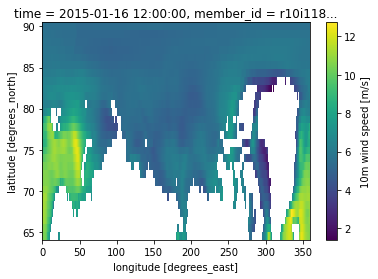

In [32]:
ws_le.isel(member_id=0,time=0).plot()

## Calculate Seasonal Means

In [33]:
season_names = ['OND','JFM', 'AMJ', 'JAS']

In [34]:
# find total years
xarr_le = ws_le.coords['time.year'][(ws_le.coords['time.month']==1)]
xarr_rufmod = ws_rufmod.coords['time.year'][(ws_rufmod.coords['time.month']==1)]

In [35]:
ws_le

,Array,Chunk
Bytes,1.55 GiB,3.69 MiB
Shape,"(50, 1032, 28, 288)","(1, 120, 28, 288)"
Count,3155 Tasks,450 Chunks
Type,float32,numpy.ndarray


In [36]:
# Loop through seasons - le

# make numpy array to fill and specify dimensions we want
seas_array_le = np.zeros([len(season_names),len(xarr_le),len(ws_le.member_id),len(ws_le.lat),len(ws_le.lon)])

for s_count, ss in enumerate(season_names):
    print(ss)
    # get temporary array of just these month by season
    if ss == 'JFM':
        temp1 = ws_le.isel(time=ws_le.time.dt.month.isin([1,2,3]))
    if ss == 'AMJ':
        temp1 = ws_le.isel(time=ws_le.time.dt.month.isin([4,5,6]))
    if ss == 'JAS':
        temp1 = ws_le.isel(time=ws_le.time.dt.month.isin([7,8,9]))
    if ss == 'OND':
        temp1 = ws_le.isel(time=ws_le.time.dt.month.isin([10,11,12]))
    # now loop through years to get the seasonal average by year for each ensemble member
    for y_count, yy in enumerate(xarr_le):
        # select only the indexes for this year
        temp2 = temp1.isel(time=temp1.time.dt.year.isin([yy]))
        temp3 = temp2.mean(dim='time')
        seas_array_le[s_count,y_count,:,:,:] = temp3    


OND
JFM
AMJ
JAS


In [37]:
# Loop through seasons - SMOOTH

# make numpy array to fill and specify dimensions we want
seas_array_rufmod = np.zeros([len(season_names),len(xarr_rufmod),len(ws_rufmod.member_id),len(ws_rufmod.lat),len(ws_rufmod.lon)])

for s_count, ss in enumerate(season_names):
    print(ss)
    # get temporary array of just these month by season
    if ss == 'JFM':
        temp1 = ws_rufmod.isel(time=ws_rufmod.time.dt.month.isin([1,2,3]))
    if ss == 'AMJ':
        temp1 = ws_rufmod.isel(time=ws_rufmod.time.dt.month.isin([4,5,6]))
    if ss == 'JAS':
        temp1 = ws_rufmod.isel(time=ws_rufmod.time.dt.month.isin([7,8,9]))
    if ss == 'OND':
        temp1 = ws_rufmod.isel(time=ws_rufmod.time.dt.month.isin([10,11,12]))
    # now loop through years to get the seasonal average by year for each ensemble member
    for y_count, yy in enumerate(xarr_rufmod):
        # select only the indexes for this year
        temp2 = temp1.isel(time=temp1.time.dt.year.isin([yy]))
        temp3 = temp2.mean(dim='time')
        seas_array_rufmod[s_count,y_count,:,:,:] = temp3    


OND
JFM
AMJ
JAS


In [38]:
print(seas_array_le.shape)
print(seas_array_rufmod.shape)


(4, 86, 50, 28, 288)
(4, 86, 5, 28, 288)


In [39]:
# convert the numpy array to a xarray for easier plotting
ws_seas_le = xr.DataArray(seas_array_le,dims=('season','time','member_id','lat','lon'))
ws_seas_rufmod = xr.DataArray(seas_array_rufmod,dims=('season','time','member_id','lat','lon'))

In [40]:
# set coordinate arrays
ws_seas_le['season'] = season_names
ws_seas_le['time'] = xarr_le
ws_seas_le['member_id'] = ws_le['member_id']
ws_seas_le['lat'] = ws_le['lat'].values
ws_seas_le['lon'] = ws_le['lon'].values

ws_seas_rufmod['season'] = season_names
ws_seas_rufmod['time'] = xarr_rufmod
ws_seas_rufmod['member_id'] = ws_rufmod['member_id']
ws_seas_rufmod['lat'] = ws_rufmod['lat'].values
ws_seas_rufmod['lon'] = ws_rufmod['lon'].values

## Calculate zonal and ensemble means

In [41]:
ws_seas_zonal_le = ws_seas_le.mean(dim='lon')
ws_seas_zonal_rufmod = ws_seas_rufmod.mean(dim='lon')

In [42]:
ws_seas_zonal_ens_mean_le = ws_seas_zonal_le.mean(dim='member_id')
ws_seas_zonal_ens_mean_rufmod = ws_seas_zonal_rufmod.mean(dim='member_id')

## Make Hovemoller-like plots at given pressure level by season

Plotting regressions for OND
Plotting regressions for JFM
Plotting regressions for AMJ
Plotting regressions for JAS


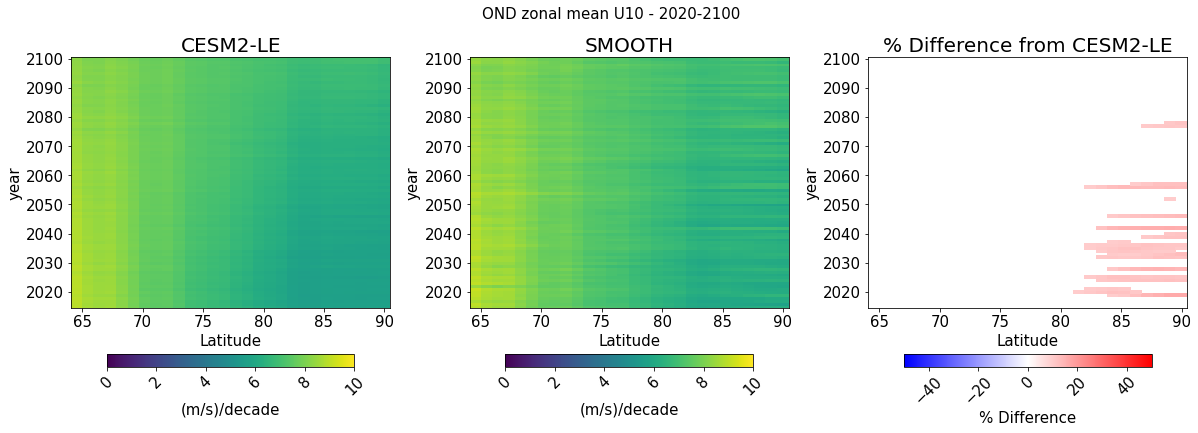

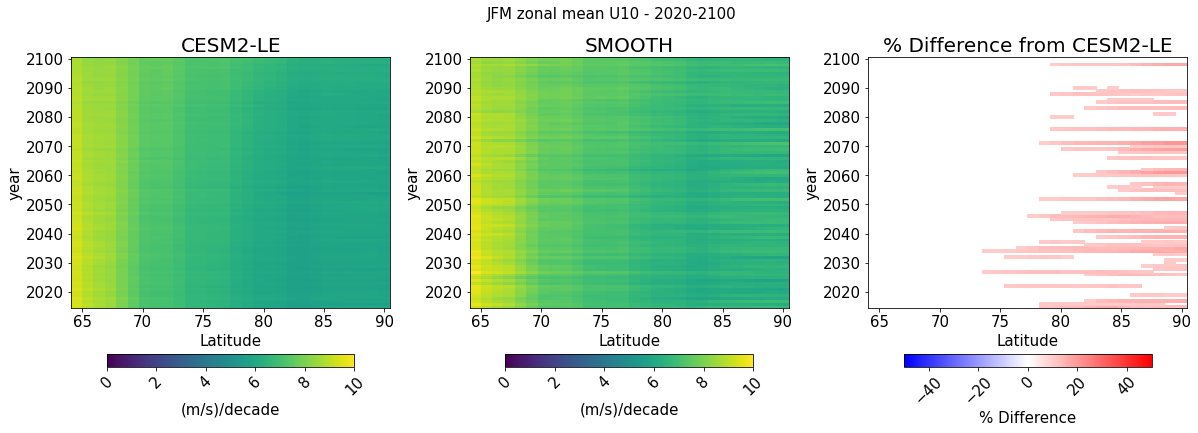

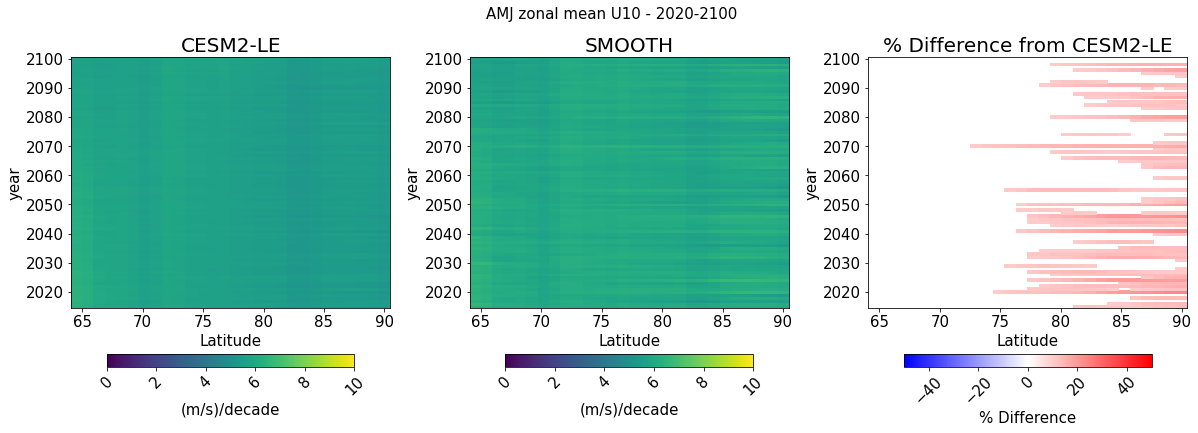

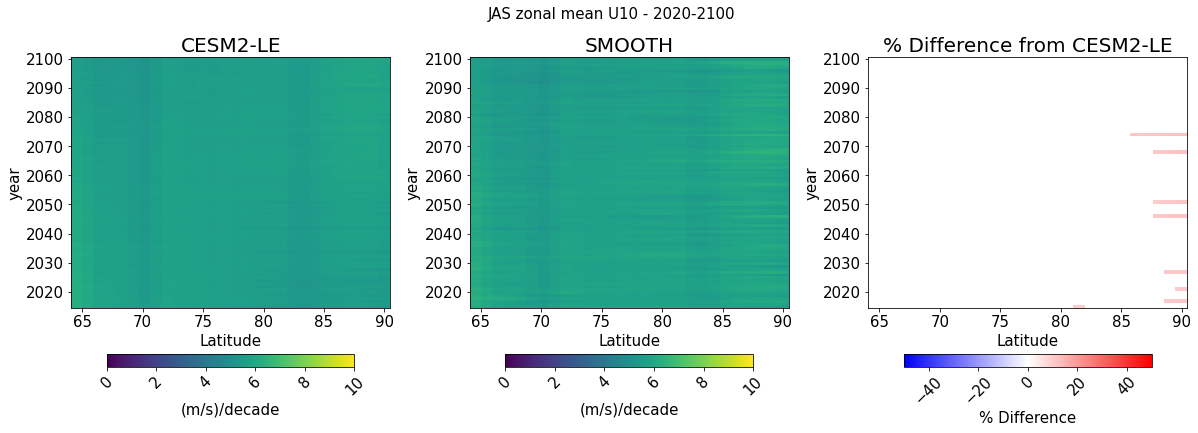

In [43]:
# set units
units = '(m/s)'

#Plot each season and percent difference
vmax_in = 10
vmin_in = 0
cmap_in = plt.cm.get_cmap('viridis')
vmax_diff = 50
vmin_diff = -50
cmap_diff = plt.cm.get_cmap('bwr')

for s_count, ss in enumerate(season_names):
    print('Plotting regressions for '+ss)
    # Grab data
    data_le = ws_seas_zonal_ens_mean_le.sel(season=ss)
    data_rufmod = ws_seas_zonal_ens_mean_rufmod.sel(season=ss)
    diff = 100*((data_rufmod - data_le)/data_le)
        
    # mask differences that are less than 10%
    diff = diff.where(abs(diff) > 10.0)
            
    # create figure
    fig = plt.figure(figsize=(20,10))
    fout = 'cesm2_le_and_rufmod_zonal_mean_hovmoller_'+var_in+'_2020_2100_'+ss
    title = ss+' zonal mean '+var_in+' - 2020-2100'

    # Make subplots - note it's nrow x ncol x index (starting upper left)
    # First subplot: CESM2-LE
    ax = fig.add_subplot(1,3,1)
    this=ax.pcolor(data_le.lat,data_le.time,data_le,
                       cmap=cmap_in,vmin=vmin_in,vmax=vmax_in)
    # colorbar stuff
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units+'/decade', fontsize=15)
    # axis limits and name stuff
    plt.xlabel('Latitude',fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylabel('year',fontsize=15)
    plt.yticks(fontsize=15)
    #plt.ylim([500,1000])
    #ax.set_ylim(ax.get_ylim()[::-1])
    plt.title('CESM2-LE',fontsize=20)
    
    # Second subplot: SMOOTH
    ax = fig.add_subplot(1,3,2)
    this=ax.pcolor(data_rufmod.lat,data_rufmod.time,data_rufmod,
                       cmap=cmap_in,vmin=vmin_in,vmax=vmax_in)
    # colorbar stuff
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel(units+'/decade', fontsize=15)
    # axis limits and name stuff
    plt.xlabel('Latitude',fontsize=15)
    plt.xticks(fontsize=15)
    #plt.xlim([2020,2100])
    plt.ylabel('year',fontsize=15)
    plt.yticks(fontsize=15)
    #plt.ylim([500,1000])
    #ax.set_ylim(ax.get_ylim()[::-1])
    plt.title('SMOOTH',fontsize=20)

    # Third subplot: Diff
    ax = fig.add_subplot(1,3,3)
    this=ax.pcolor(diff.lat,diff.time,diff,
                       cmap=cmap_diff,vmin=vmin_diff,vmax=vmax_diff)
    # colorbar stuff
    cbar = plt.colorbar(this,orientation='horizontal',fraction=0.04)
    cbar.ax.tick_params(labelsize=15, labelrotation=45)
    cbar.ax.set_xlabel('% Difference', fontsize=15)
    # axis limits and name stuff
    plt.xlabel('Latitude',fontsize=15)
    plt.xticks(fontsize=15)
    #plt.xlim([2020,2100])
    plt.ylabel('year',fontsize=15)
    plt.yticks(fontsize=15)
    #plt.ylim([500,1000])
    #ax.set_ylim(ax.get_ylim()[::-1])
    plt.title('% Difference from CESM2-LE',fontsize=20)
    
    # Finalize figure and save
    fig.suptitle(title,fontsize=15, y=0.95)  
    fig.subplots_adjust(bottom=0.45,wspace=0.25)
    fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200) 
